## Muscimol experiment analyses

In [4]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import data_utils, spike_utils

In [7]:
muscimol_session_id='712141_2024-06-10'
control_session_id='712141_2024-06-11'

muscimol_session = DynamicRoutingSession(muscimol_session_id)
control_session = DynamicRoutingSession(control_session_id)

muscimol_trials=data_utils.load_trials_or_units(muscimol_session,'trials')
control_trials=data_utils.load_trials_or_units(control_session,'trials')

muscimol_units=data_utils.load_trials_or_units(muscimol_session,'units')
control_units=data_utils.load_trials_or_units(control_session,'units')

712141_2024-06-10 cached trials not found, loading with npc_sessions
712141_2024-06-11 cached trials not found, loading with npc_sessions


stim_path = <HDF5 file "<_io.BytesIO object at 0x000001D38EFE31A0>" (mode r)> matched to sync block using n_stim_frames = 51336, but failed to match frame times using stim_start_time = datetime.datetime(2024, 6, 11, 11, 50, 45) with sync_data.start_time = datetime.datetime(2024, 6, 11, 11, 50, 6, 529843), expected stim_start_time_on_sync = 38. Sync or stim file may have the wrong start-time info.


712141_2024-06-10 cached units not found, loading with npc_sessions


fetching units: 100%|█████████████████████████| 5/5 [01:41<00:00, 20.28s/device]
c:\Anaconda3\envs\dr_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\dr_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\dr_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\dr_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  retu

712141_2024-06-11 cached units not found, loading with npc_sessions


fetching units: 100%|█████████████████████████| 5/5 [01:10<00:00, 14.20s/device]
c:\Anaconda3\envs\dr_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\dr_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\dr_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\dr_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  retu

## plot n units per probe for control and muscimol

Text(0.5, 0.98, 'Muscimol (712141_2024-06-10) vs Control (712141_2024-06-11): Number of Units by Probe')

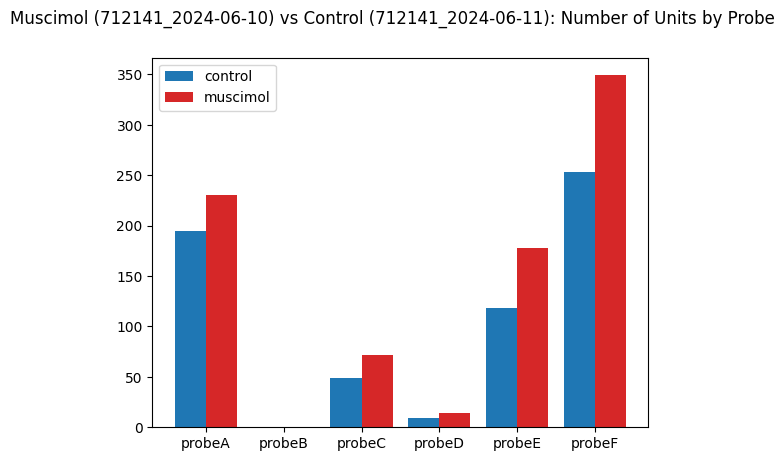

In [8]:
probe_names = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']

fig,ax=plt.subplots(1,1)

for i,probe_name in enumerate(probe_names):
    
    muscimol_units_probe = muscimol_units.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')
    control_units_probe = control_units.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')

    ax.bar(i-0.2,len(control_units_probe),color='tab:blue',label='muscimol',width=0.4)
    ax.bar(i+0.2,len(muscimol_units_probe),color='tab:red',label='muscimol',width=0.4)

ax.set_xticks(range(6))
ax.set_xticklabels(probe_names)
ax.legend(['control','muscimol'])

fig.suptitle('Muscimol ('+muscimol_session_id+') vs Control ('+control_session_id+'): Number of Units by Probe')

## plot average firing rate per channel across probes

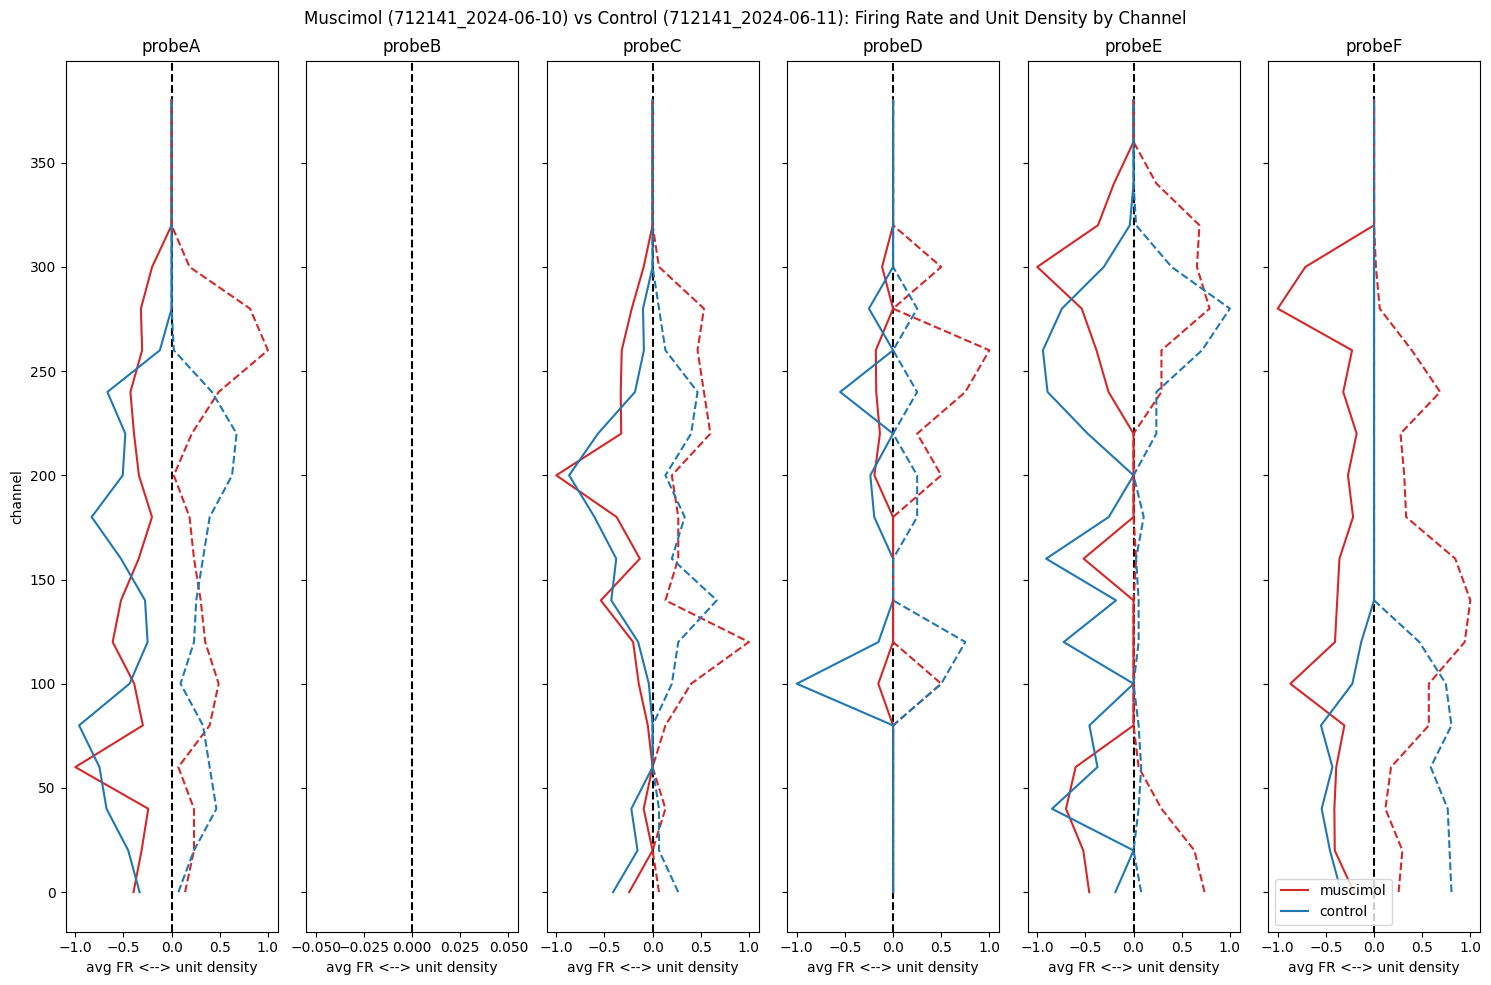

In [9]:
probe_names = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']

results_by_probe = {
    'probe_name': [],
    'muscimol_fr': [],
    'control_fr': [],
    'muscimol_unit_density': [],
    'control_unit_density': [],
    'fr_max':[],
    'unit_density_max':[],
}

channel_bin_size = 20

#loop through probes, make channel-wise firing rate and unit density arrays for control and muscimol

for probe_name in probe_names:

    muscimol_units_probe = muscimol_units.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')
    control_units_probe = control_units.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')

    channel_bins=np.arange(0,384,channel_bin_size)

    muscimol_probe_frs = []
    control_probe_frs = []
    muscimol_probe_unit_densities = []
    control_probe_unit_densities = []

    for ch in channel_bins:
        muscimol_units_probe_ch = muscimol_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')
        control_units_probe_ch = control_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')

        if len(muscimol_units_probe_ch)==0:
            muscimol_probe_frs.append(0)
            muscimol_probe_unit_densities.append(0)
        elif len(muscimol_units_probe_ch)>0:
            muscimol_probe_frs.append(muscimol_units_probe_ch['firing_rate'].mean())
            muscimol_probe_unit_densities.append(len(muscimol_units_probe_ch))
        
        if len(control_units_probe_ch)==0:
            control_probe_frs.append(0)
            control_probe_unit_densities.append(0)
        elif len(control_units_probe_ch)>0:
            control_probe_frs.append(control_units_probe_ch['firing_rate'].mean())
            control_probe_unit_densities.append(len(control_units_probe_ch))

    results_by_probe['probe_name'].append(probe_name)
    results_by_probe['muscimol_fr'].append(np.array(muscimol_probe_frs))
    results_by_probe['control_fr'].append(np.array(control_probe_frs))
    results_by_probe['muscimol_unit_density'].append(np.array(muscimol_probe_unit_densities))
    results_by_probe['control_unit_density'].append(np.array(control_probe_unit_densities))
    results_by_probe['fr_max'].append(max(np.nanmax(muscimol_probe_frs),np.nanmax(control_probe_frs)))
    results_by_probe['unit_density_max'].append(max(np.nanmax(muscimol_probe_unit_densities),np.nanmax(control_probe_unit_densities)))

results_by_probe_df=pd.DataFrame(results_by_probe).set_index('probe_name')

fig,ax=plt.subplots(1,6,figsize=(15,10),sharey=True)

for i,probe_name in enumerate(probe_names):
    probe_data=results_by_probe_df.loc[probe_name]
    ax[i].axvline(0,color='k',linestyle='--')
    ax[i].plot(-probe_data['muscimol_fr']/probe_data['fr_max'],channel_bins,label='muscimol',color='tab:red')
    ax[i].plot(-probe_data['control_fr']/probe_data['fr_max'],channel_bins,label='control',color='tab:blue')
    ax[i].plot(probe_data['muscimol_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:red',linestyle='--')
    ax[i].plot(probe_data['control_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:blue',linestyle='--')
    ax[i].set_title(probe_name)
    ax[i].set_xlabel('avg FR <--> unit density')
    if i==5:
        ax[i].legend()
    elif i==0:
        ax[i].set_ylabel('channel')

fig.suptitle('Muscimol ('+muscimol_session_id+') vs Control ('+control_session_id+'): Firing Rate and Unit Density by Channel')
fig.tight_layout()
    

## get single unit modulation info

In [10]:
unit_modulation_control = spike_utils.compute_stim_context_modulation(control_trials, control_units, npc_lims.get_session_info(control_session.id), save_path=None)
unit_modulation_muscimol = spike_utils.compute_stim_context_modulation(muscimol_trials, muscimol_units, npc_lims.get_session_info(muscimol_session.id), save_path=None)

In [11]:
# see all columns
unit_modulation_muscimol.columns.values

array(['amplitude_cutoff', 'amplitude_cv_median', 'amplitude_cv_range',
       'amplitude_median', 'drift_ptp', 'drift_std', 'drift_mad',
       'firing_range', 'firing_rate', 'isi_violations_ratio',
       'isi_violations_count', 'num_spikes', 'presence_ratio',
       'rp_contamination', 'rp_violations', 'sliding_rp_violation', 'snr',
       'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'd_prime',
       'isolation_distance', 'l_ratio', 'silhouette', 'nn_hit_rate',
       'nn_miss_rate', 'exp_decay', 'half_width', 'num_negative_peaks',
       'num_positive_peaks', 'peak_to_valley', 'peak_trough_ratio',
       'recovery_slope', 'repolarization_slope', 'spread',
       'velocity_above', 'velocity_below', 'electrode_group_name',
       'peak_channel', 'cluster_id', 'default_qc', 'amplitude', 'unit_id',
       'peak_electrode', 'obs_intervals', 'electrode_group', 'session_id',
       'project', 'baseline_context_modulation_index',
       'baseline_context_modulation_p_value',
       'ba

### useful metrics:

'vis1_stimulus_modulation_zscore': how much a unit is modulated by vis1, normalized to baseline mean and stdev

'vis1_stimulus_modulation_p_value': is unit significantly modulated by vis1? (Wilcoxon sign-rank test)

'vis2_stimulus_modulation_zscore'

'vis2_stimulus_modulation_p_value'

'sound1_stimulus_modulation_zscore'

'sound1_stimulus_modulation_p_value'

'sound2_stimulus_modulation_zscore'

'sound2_stimulus_modulation_p_value'

'baseline_context_modulation_zscore': how much is the baseline modulated in vis vs. aud context? Positive = higher in vis

'baseline_context_modulation_p_value': is baseline modulation significant? (Mann-Whitney U test)
       

## plot unit metric across channels with some p-value filter

how strong were stimulus responses in those units that were significantly stimulus responsive?

(set p_value_threshold=1.1 to not filter by p-value)

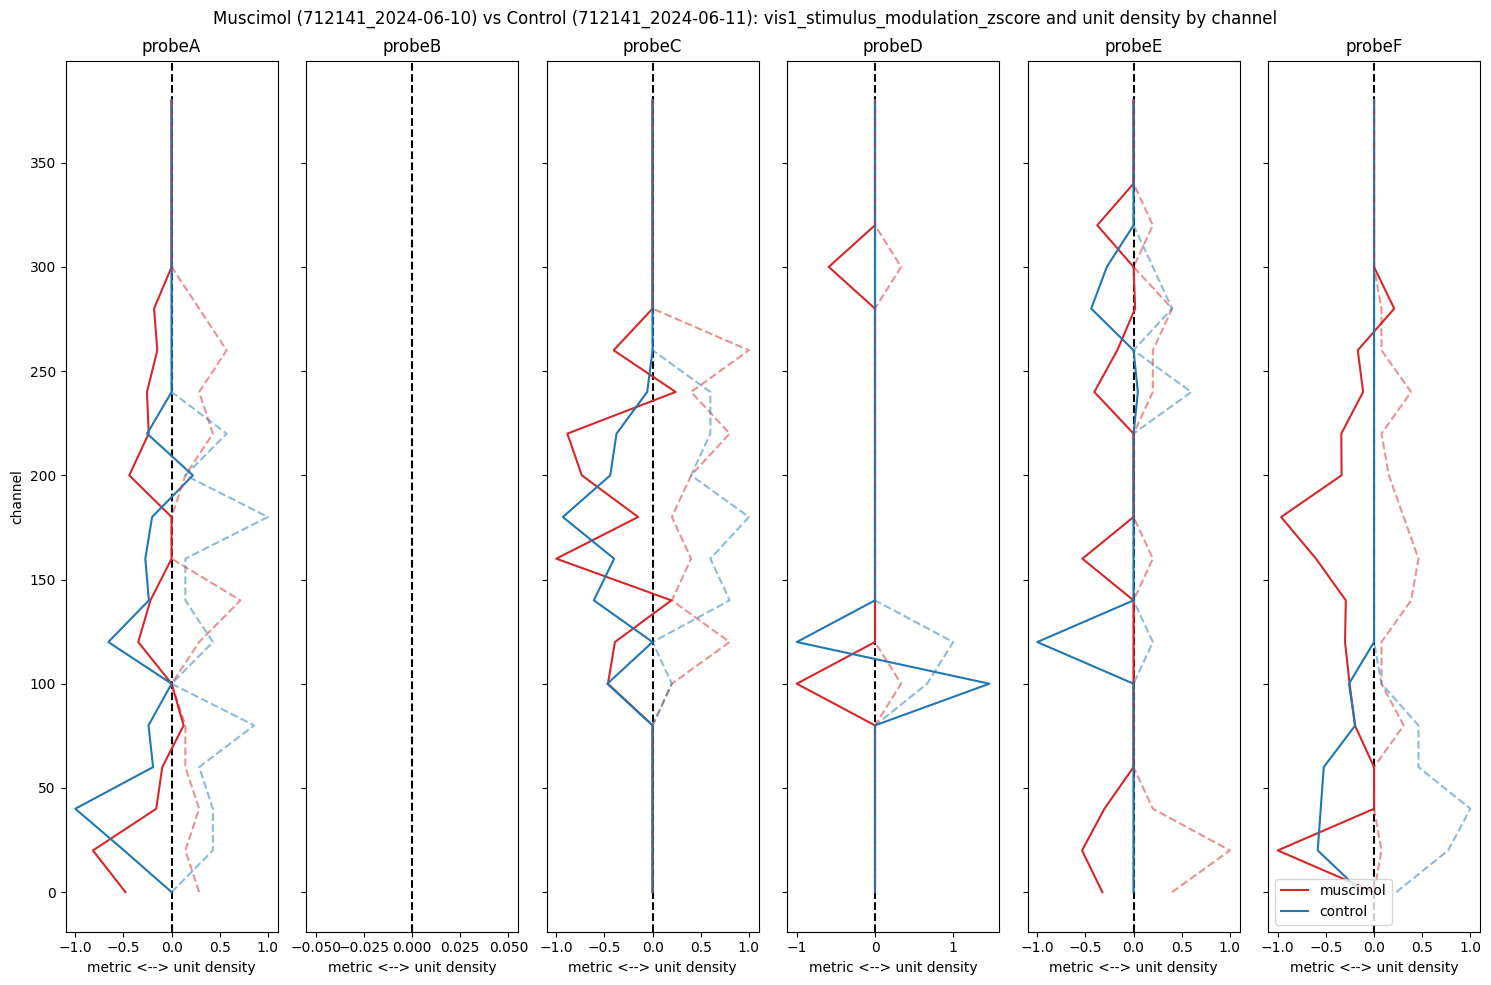

In [12]:
sel_metric='vis1_stimulus_modulation_zscore'
sel_pval='vis1_stimulus_modulation_p_value'
p_value_threshold=0.05

probe_names = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']

results_by_probe = {
    'probe_name': [],
    'muscimol_metric': [],
    'control_metric': [],
    'muscimol_unit_density': [],
    'control_unit_density': [],
    'metric_max':[],
    'unit_density_max':[],
}

channel_bin_size = 20

#loop through probes, make channel-wise firing rate and unit density arrays for control and muscimol

for probe_name in probe_names:
    muscimol_units_probe = unit_modulation_muscimol.query('electrode_group_name==@probe_name and '+sel_pval+'<@p_value_threshold').sort_values(by='peak_channel')
    control_units_probe = unit_modulation_control.query('electrode_group_name==@probe_name and '+sel_pval+'<@p_value_threshold').sort_values(by='peak_channel')

    channel_bins=np.arange(0,384,channel_bin_size)

    muscimol_probe_frs = []
    control_probe_frs = []
    muscimol_probe_unit_densities = []
    control_probe_unit_densities = []

    for ch in channel_bins:
        muscimol_units_probe_ch = muscimol_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')
        control_units_probe_ch = control_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')

        if len(muscimol_units_probe_ch)==0:
            muscimol_probe_frs.append(0)
            muscimol_probe_unit_densities.append(0)
        elif len(muscimol_units_probe_ch)>0:
            muscimol_probe_frs.append(muscimol_units_probe_ch[sel_metric].mean())
            muscimol_probe_unit_densities.append(len(muscimol_units_probe_ch))
        
        if len(control_units_probe_ch)==0:
            control_probe_frs.append(0)
            control_probe_unit_densities.append(0)
        elif len(control_units_probe_ch)>0:
            control_probe_frs.append(control_units_probe_ch[sel_metric].mean())
            control_probe_unit_densities.append(len(control_units_probe_ch))

    results_by_probe['probe_name'].append(probe_name)
    results_by_probe['muscimol_metric'].append(np.array(muscimol_probe_frs))
    results_by_probe['control_metric'].append(np.array(control_probe_frs))
    results_by_probe['muscimol_unit_density'].append(np.array(muscimol_probe_unit_densities))
    results_by_probe['control_unit_density'].append(np.array(control_probe_unit_densities))
    results_by_probe['metric_max'].append(max(np.nanmax(muscimol_probe_frs),np.nanmax(control_probe_frs)))
    results_by_probe['unit_density_max'].append(max(np.nanmax(muscimol_probe_unit_densities),np.nanmax(control_probe_unit_densities)))

results_by_probe_df=pd.DataFrame(results_by_probe).set_index('probe_name')

fig,ax=plt.subplots(1,6,figsize=(15,10),sharey=True)

for i,probe_name in enumerate(probe_names):
    probe_data=results_by_probe_df.loc[probe_name]
    ax[i].axvline(0,color='k',linestyle='--')
    ax[i].plot(-probe_data['muscimol_metric']/probe_data['metric_max'],channel_bins,label='muscimol',color='tab:red')
    ax[i].plot(-probe_data['control_metric']/probe_data['metric_max'],channel_bins,label='control',color='tab:blue')
    ax[i].plot(probe_data['muscimol_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:red',linestyle='--',alpha=0.5)
    ax[i].plot(probe_data['control_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:blue',linestyle='--',alpha=0.5)
    ax[i].set_title(probe_name)
    ax[i].set_xlabel('metric <--> unit density')
    if i==5:
        ax[i].legend()
    elif i==0:
        ax[i].set_ylabel('channel')

fig.suptitle('Muscimol ('+muscimol_session_id+') vs Control ('+control_session_id+'): '+sel_metric+' and unit density by channel')
fig.tight_layout()
    

## plot fraction of units modulated according to some p value

what fraction of units on a probe significantly responded to a stimulus?

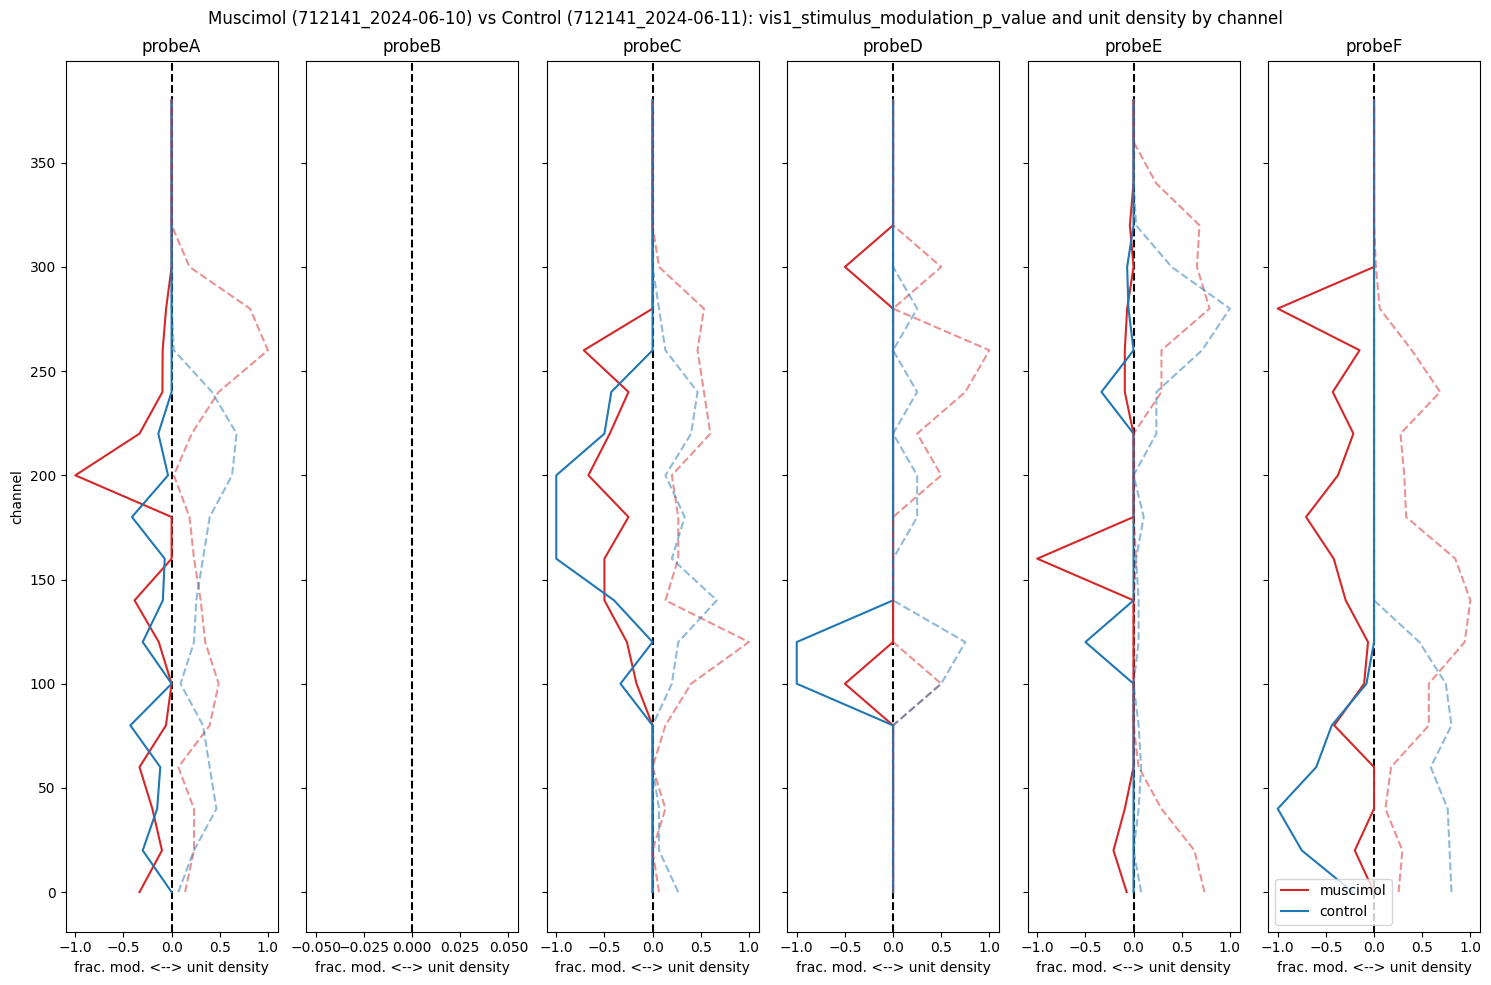

In [13]:
sel_pval='vis1_stimulus_modulation_p_value'
p_value_threshold=0.05

probe_names = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']

results_by_probe = {
    'probe_name': [],
    'muscimol_metric': [],
    'control_metric': [],
    'muscimol_unit_density': [],
    'control_unit_density': [],
    'metric_max':[],
    'unit_density_max':[],
}

channel_bin_size = 20

#loop through probes, make channel-wise firing rate and unit density arrays for control and muscimol

for probe_name in probe_names:
    muscimol_units_probe = unit_modulation_muscimol.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')
    control_units_probe = unit_modulation_control.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')

    channel_bins=np.arange(0,384,channel_bin_size)

    muscimol_probe_frs = []
    control_probe_frs = []
    muscimol_probe_unit_densities = []
    control_probe_unit_densities = []

    for ch in channel_bins:
        muscimol_units_probe_ch = muscimol_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')
        control_units_probe_ch = control_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')

        if len(muscimol_units_probe_ch)==0:
            muscimol_probe_frs.append(0)
            muscimol_probe_unit_densities.append(0)
        elif len(muscimol_units_probe_ch)>0:
            muscimol_probe_frs.append((muscimol_units_probe_ch[sel_pval]<p_value_threshold).mean())
            muscimol_probe_unit_densities.append(len(muscimol_units_probe_ch))
        
        if len(control_units_probe_ch)==0:
            control_probe_frs.append(0)
            control_probe_unit_densities.append(0)
        elif len(control_units_probe_ch)>0:
            control_probe_frs.append((control_units_probe_ch[sel_pval]<p_value_threshold).mean())
            control_probe_unit_densities.append(len(control_units_probe_ch))

    results_by_probe['probe_name'].append(probe_name)
    results_by_probe['muscimol_metric'].append(np.array(muscimol_probe_frs))
    results_by_probe['control_metric'].append(np.array(control_probe_frs))
    results_by_probe['muscimol_unit_density'].append(np.array(muscimol_probe_unit_densities))
    results_by_probe['control_unit_density'].append(np.array(control_probe_unit_densities))
    results_by_probe['metric_max'].append(max(np.nanmax(muscimol_probe_frs),np.nanmax(control_probe_frs)))
    results_by_probe['unit_density_max'].append(max(np.nanmax(muscimol_probe_unit_densities),np.nanmax(control_probe_unit_densities)))

results_by_probe_df=pd.DataFrame(results_by_probe).set_index('probe_name')

fig,ax=plt.subplots(1,6,figsize=(15,10),sharey=True)

for i,probe_name in enumerate(probe_names):
    probe_data=results_by_probe_df.loc[probe_name]
    ax[i].axvline(0,color='k',linestyle='--')
    ax[i].plot(-probe_data['muscimol_metric']/probe_data['metric_max'],channel_bins,label='muscimol',color='tab:red')
    ax[i].plot(-probe_data['control_metric']/probe_data['metric_max'],channel_bins,label='control',color='tab:blue')
    ax[i].plot(probe_data['muscimol_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:red',linestyle='--',alpha=0.5)
    ax[i].plot(probe_data['control_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:blue',linestyle='--',alpha=0.5)
    ax[i].set_title(probe_name)
    ax[i].set_xlabel('frac. mod. <--> unit density')
    if i==5:
        ax[i].legend()
    elif i==0:
        ax[i].set_ylabel('channel')

fig.suptitle('Muscimol ('+muscimol_session_id+') vs Control ('+control_session_id+'): '+sel_pval+' and unit density by channel')
fig.tight_layout()
    

## barplots of fraction stimulus responsive units per probe

In [14]:
p_value_threshold=0.05

probe_names = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']
stim_names = ['vis1','vis2','sound1','sound2']

results_by_probe = {
    'probe_name': [],
    'muscimol_vis1_frac': [],
    'control_vis1_frac': [],
    'muscimol_vis2_frac': [],
    'control_vis2_frac': [],
    'muscimol_sound1_frac': [],
    'control_sound1_frac': [],
    'muscimol_sound2_frac': [],
    'control_sound2_frac': [],
}

#loop through probes, make channel-wise firing rate and unit density arrays for control and muscimol

for probe_name in probe_names:
    muscimol_units_probe = unit_modulation_muscimol.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')
    control_units_probe = unit_modulation_control.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')

    channel_bins=np.arange(0,384,channel_bin_size)

    results_by_probe['probe_name'].append(probe_name)
    for ss in stim_names:
        results_by_probe['muscimol_'+ss+'_frac'].append((muscimol_units_probe[ss+'_stimulus_modulation_p_value']<p_value_threshold).mean())
        results_by_probe['control_'+ss+'_frac'].append((control_units_probe[ss+'_stimulus_modulation_p_value']<p_value_threshold).mean())

results_by_probe_df=pd.DataFrame(results_by_probe).set_index('probe_name')

results_by_probe_df
    

,muscimol_vis1_frac,control_vis1_frac,muscimol_vis2_frac,control_vis2_frac,muscimol_sound1_frac,control_sound1_frac,muscimol_sound2_frac,control_sound2_frac
probe_name,,,,,,,,
probeA,0.113043,0.158974,0.108696,0.107692,0.234783,0.276923,0.286957,0.271795
probeB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
probeC,0.305556,0.428571,0.222222,0.265306,0.208333,0.285714,0.152778,0.387755
probeD,0.142857,0.555556,0.214286,0.444444,0.071429,0.111111,0.142857,0.222222
probeE,0.078652,0.059322,0.056180,0.084746,0.157303,0.211864,0.202247,0.220339
probeF,0.091691,0.154150,0.057307,0.118577,0.143266,0.284585,0.166189,0.308300


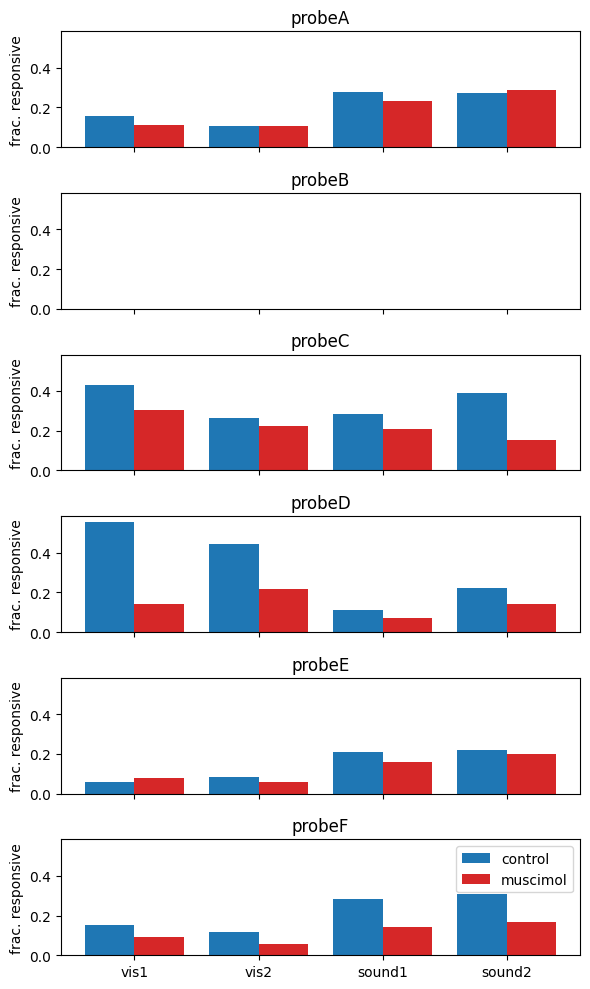

In [15]:
fig,ax=plt.subplots(6,1,figsize=(6,10),sharey=True,sharex=True)

for i,probe_name in enumerate(probe_names):
    probe_data=results_by_probe_df.loc[probe_name]

    for ss,stim_name in enumerate(stim_names):
        ax[i].bar(ss-0.2,probe_data['control_'+stim_name+'_frac'],color='tab:blue',label='control',width=0.4)
        ax[i].bar(ss+0.2,probe_data['muscimol_'+stim_name+'_frac'],color='tab:red',label='muscimol',width=0.4)
        ax[i].set_title(probe_name)
        ax[i].set_ylabel('frac. responsive')
ax[i].set_xticks(range(4))
ax[i].set_xticklabels(stim_names)
ax[i].legend(['control','muscimol'])

fig.tight_layout()

## barplots of fraction stimulus responsive units per area (if have area info)

what fraction of units in each area responded to stimuli?

In [16]:
p_value_threshold=0.05

if 'structure' in unit_modulation_muscimol.columns:
    areas_control = unit_modulation_muscimol['structure'].unique()
    areas_muscimol = unit_modulation_control['structure'].unique()
    areas=np.unique(np.concatenate([areas_control,areas_muscimol]))
else:
    areas=[]
    print('no area info')

stim_names = ['vis1','vis2','sound1','sound2']

results_by_area = {
    'area': [],
    'muscimol_vis1_frac': [],
    'control_vis1_frac': [],
    'muscimol_vis2_frac': [],
    'control_vis2_frac': [],
    'muscimol_sound1_frac': [],
    'control_sound1_frac': [],
    'muscimol_sound2_frac': [],
    'control_sound2_frac': [],
}

#loop through probes, make channel-wise firing rate and unit density arrays for control and muscimol

for area in areas:

    muscimol_units_area = unit_modulation_muscimol.query('structure==@area').sort_values(by='peak_channel')
    control_units_area = unit_modulation_control.query('structure==@area').sort_values(by='peak_channel')

    results_by_area['area'].append(area)
    for ss in stim_names:
        results_by_area['muscimol_'+ss+'_frac'].append((muscimol_units_area[ss+'_stimulus_modulation_p_value']<p_value_threshold).mean())
        results_by_area['control_'+ss+'_frac'].append((control_units_area[ss+'_stimulus_modulation_p_value']<p_value_threshold).mean())

results_by_area_df=pd.DataFrame(results_by_area).set_index('area')
results_by_area_df
    

no area info


,muscimol_vis1_frac,control_vis1_frac,muscimol_vis2_frac,control_vis2_frac,muscimol_sound1_frac,control_sound1_frac,muscimol_sound2_frac,control_sound2_frac
area,,,,,,,,


In [ ]:
#bar plot for every area
for aa,area in enumerate(areas):
    fig,ax=plt.subplots(1,1)
    
    area_data=results_by_probe_df.loc[area]

    for ss,stim_name in enumerate(stim_names):
        ax.bar(ss-0.2,probe_data['control_'+stim_name+'_frac'],color='tab:blue',label='control',width=0.4)
        ax.bar(ss+0.2,probe_data['muscimol_'+stim_name+'_frac'],color='tab:red',label='muscimol',width=0.4)
        ax.set_title(area)
        ax.set_ylabel('frac. responsive')
    ax.set_xticks(range(4))
    ax.set_xticklabels(stim_names)
    ax.legend(['control','muscimol'])
    fig.tight_layout()